In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import scipy.stats

import warnings
warnings.simplefilter('ignore')

In [ ]:
pd.options.display.max_rows = 100

In [ ]:
df = pd.read_csv('../data/data.csv', parse_dates=['created_at'])
df.shape

(5000, 7)

In [ ]:
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 04:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11


### Naive AOV method : 

In [ ]:
df['order_amount'].mean()

3145.128

Lets check why is the reason that we're getting such a high average order value when each shop only sells only one kind of sneaker(which are usually cheap)

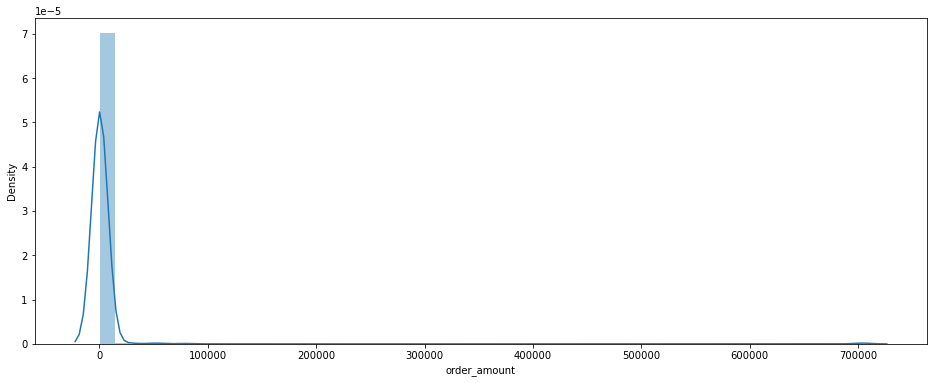

In [ ]:
# Order Amount Distribution Plot

plt.figure(figsize=(16, 6))
sns.distplot(df['order_amount'])
plt.show()

It seems that we have too many outliers (right skewed) which is causing our average be very high than normal.

In [ ]:
df[['order_amount']].describe()

,order_amount
count,5000.000000
mean,3145.128000
std,41282.539349
min,90.000000
25%,163.000000
50%,284.000000
75%,390.000000
max,704000.000000


Here we can see that almost 75% of the order amounts is <=390.

## To tackle this problem I have two kind of approaches : 

- Approach A : Here we change the evaluation metric (currently AOV (average order value)) which is robust to outliers.
- Approach B : Here we keep the evaluation metric (currently AOV (average order value)) intact but change the data distribution i.e remove the outliers. 

## Approach A

In this approach I'm presenting two metrics which can be used : 

1. Percentile / Quantile Method : We can assume a quantile number (example : 0.8 quantile) as quantiles/percentiles are robust against outliers.
2. Median : A simple and naive solution to outliers

In [ ]:
# A.1. Percentile / Quantile Method : 
## I'm assuming quantile as 0.8 here : 

quantile_val = 0.8
result = np.quantile(df['order_amount'], quantile_val)

print(f"Value Reported using Approach A.1 (Percentile Method): {result: .2f}")

Value Reported using Approach A.1 (Percentile Method):  444.00


In [ ]:
# A.2. Percentile / Quantile Method : 

result = df['order_amount'].median()

print(f"Value Reported using Approach A.2 (Median Method): {result: .2f}")

Value Reported using Approach A.2 (Median Method):  284.00


## Approach B

In this approach I make changes to the internal data distribution instead of change the evaluation metric i.e in laymann terms removing the outliers.

NOTE :: The evaluation metric is kept the same i.e AOV (Average Order Value)

### To remove outliers I'm using z-score method
I'm considering a 3-sigma as a good value to remove most outliers i.e any datapoint which is 3 standard deviations aways from mean would be removed.

In [ ]:
def outlier_removal(df: pd.DataFrame, sigma: int=3): 
    df['zscore'] = (df.order_amount - df.order_amount.mean() ) / df.order_amount.std()
    
    print("Removing the below Outliers :")
    print(df[(df['zscore'] >= +(sigma)) | (df['zscore'] <= -(sigma))][['order_amount']])
    
    # standard deviation  >+-3sigma
    df = df[(df['zscore'] <= +(sigma)) & (df['zscore'] >= -(sigma))]
   
    return df

In [ ]:
df_no_outliers = outlier_removal(df[['order_amount']], sigma=3)
df_no_outliers.shape, df.shape

Removing the below Outliers :
      order_amount
15          704000
60          704000
520         704000
691         154350
1104        704000
1362        704000
1436        704000
1562        704000
1602        704000
2153        704000
2297        704000
2835        704000
2969        704000
3332        704000
4056        704000
4646        704000
4868        704000
4882        704000


((4982, 2), (5000, 7))

We can see that 18 records/outliers have been removed by this method and all of those orders have very high order amount.

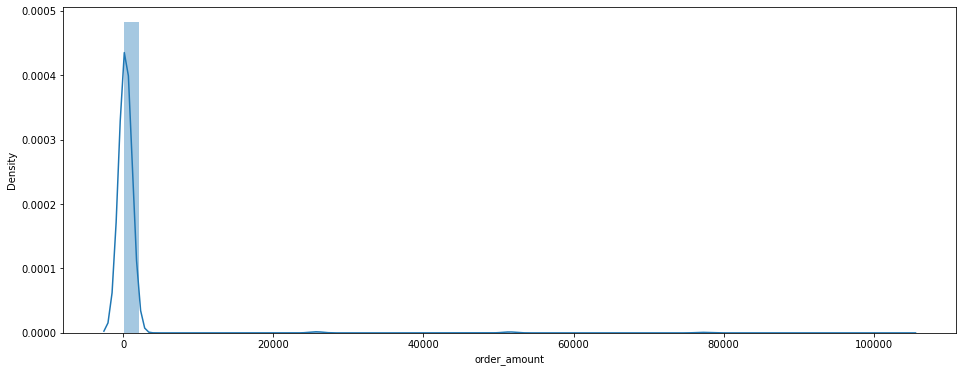

In [ ]:
# New Order Amount Distribution Plot

plt.figure(figsize=(16, 6))
sns.distplot(df_no_outliers['order_amount'])
plt.show()

Even though we can still see a right skew but that can all be tuned by changing our sigma value while removing outliers.

### Recalculating all the evaluation metrics after removing outliers : 

In [ ]:
# Average Order Value (AOV) : 

result = df_no_outliers['order_amount'].mean()
print(f"Average Order Value after removal of Outliers : {result: .2f}")

Average Order Value after removal of Outliers :  723.26


Just after removal of 18 outliers we can see that the AOV has dropped from **3145.128 to 723.26**

In [ ]:
# A.1. Percentile / Quantile Method : 
## I'm assuming quantile as 0.8 here : 

quantile_val = 0.8
result = np.quantile(df_no_outliers['order_amount'], quantile_val)

print(f"Value Reported using Approach A.1 (Percentile Method) after removal of Outliers: {result: .2f}")

Value Reported using Approach A.1 (Percentile Method) after removal of Outliers:  440.40


Even after removal of outliers we can see that the **this evalution metric score has not changed much** | **444.00 to 440.40**; this indicates that this method is **very robust to outliers**

In [ ]:
# A.2. Percentile / Quantile Method : 

result = df_no_outliers['order_amount'].median()

print(f"Value Reported using Approach A.2 (Median Method): {result: .2f}")

Value Reported using Approach A.2 (Median Method):  284.00


Median is always **constant** i.e no change